In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print(f"IN_COLAB = {IN_COLAB}")

if IN_COLAB:
    !python --version
    %cd /content
    !rm -rf adt_evaluation/
    %pip install backports.cached-property dominate
    !git clone https://bitbucket.org/ambidecodertoolbox/adt_evaluation.git

IN_COLAB = False


In [3]:
from pathlib import Path
import os

from numpy import pi as π

import example_speaker_arrays as esa
import optimize_dome as od
import program_channels as pc
import localization_models as lm

import write_faust_decoder as wfd

import numpy as np

# %% globals

# __file__ is not defined in some notebook environments, so get it the wd the old fashioned way
try:
    _here = Path(__file__).parent
except NameError as ne:
    import os
    _here = Path(os.getcwd())
print(_here)

/Users/heller/Documents/adt_evaluation


In [5]:
# set elevation limits

# optimization -- typically a little outside the limits of the speaker array
#  rE goal is AO+1 inside the limit, AO-2 outside.
#  TODO: I should probably provide some user control over the AOs that the optimizer uses...
el_lim = np.array((-30, 60)) * np.pi / 180

# evaluation -- 
eval_el_lim = np.array((-45, 89)) * np.pi / 180

quiet = False  # True will supress plots

In [6]:
def make_decoder(C, S, el_lim, eval_el_lim):
    M_hf, result_dict_hf = od.optimize_dome(
            S,
            ambisonic_order=C,
            # eval_order=C,
            sparseness_penalty=1,
            el_lim=el_lim,
            do_report=True,
            random_start=False,
            eval_el_lim=eval_el_lim,
            quiet=quiet,
        )
    M_lf, result_dict_lf = od.optimize_dome_LF(
            M_hf,
            S.real_only(),
            ambisonic_order=C,
            el_lim=el_lim,
        )
    return M_hf, M_lf, result_dict_hf, result_dict_lf
    

ac: AER
ac: XZY
SphericalData(CCRMA-Stage) SphericalData(imaginary speaker at nadir)


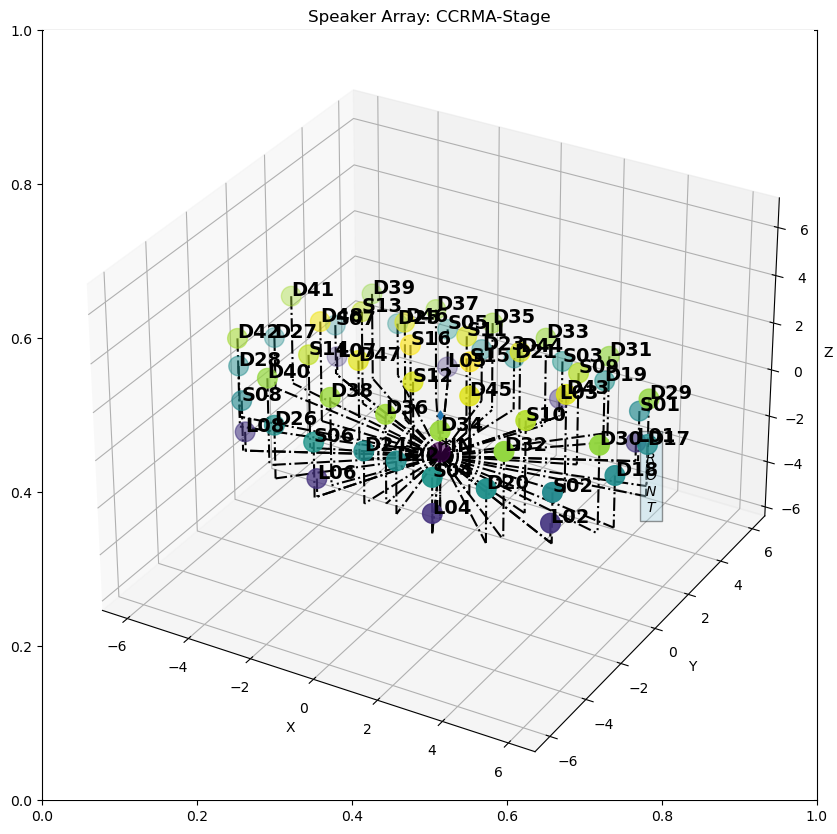

/Users/heller/Documents/adt_evaluation/plot_utils.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


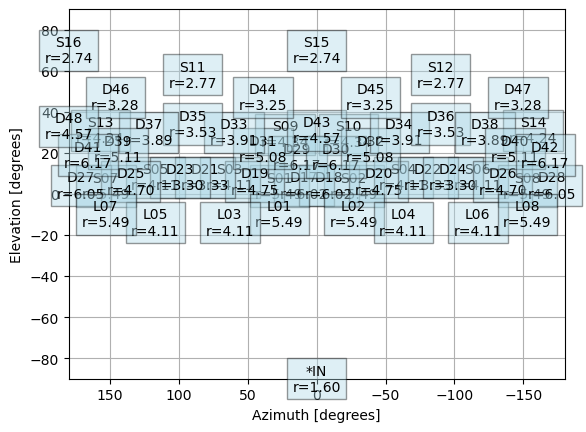

In [7]:
#%matplotlib tk
#%matplotlib ipympl

#S = esa.emb_cmap884(bottom_ring=True)
S = esa.stage2017()
S.plot3D(show=True)
S.plot_azel(show=True)
None

In [6]:
S.real_only().r

array([5.4864, 5.4864, 4.1148, 4.1148, 4.1148, 4.1148, 5.4864, 5.4864,
       4.3434, 4.3434, 2.7686, 2.7686, 4.2418, 4.2418, 2.7432, 2.7432,
       6.0198, 6.0198, 4.7498, 4.7498, 3.3274, 3.3274, 3.302 , 3.302 ,
       4.699 , 4.699 , 6.0452, 6.0452, 6.1722, 6.1722, 5.08  , 5.08  ,
       3.9116, 3.9116, 3.5306, 3.5306, 3.8862, 3.8862, 5.1054, 5.1054,
       6.1722, 6.1722, 4.572 , 3.2512, 3.2512, 3.2766, 3.2766, 4.572 ,
       5.4864, 5.4864, 4.1148, 4.1148, 4.1148, 4.1148, 5.4864, 5.4864])

In [8]:
C = pc.ChannelsN3D(3, 3)
#C = pc.ChannelsAmbiX(3, 3)
#C = pc.ChannelsFuMa(3, 3)

print(C.sh_l)
print(C.sh_m)
print(C.channel_names)
print(C.normalization)

[0 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3]
[ 0 -1  0  1 -2 -1  0  1  2 -3 -2 -1  0  1  2  3]
['W', 'Y', 'Z', 'X', 'V', 'T', 'R', 'S', 'U', 'Q', 'O', 'M', 'K', 'L', 'N', 'P']
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
#do = enumerate((ho, vo) for ho in range(1,4) for vo in range(1, ho+1))

do = enumerate((o, o) for o in range(6, 7))
dsps = []

def run_it():
    try:
        i, (ho, vo) = next(do)
    except StopIteration:
        print("Done!")
    else:
        C = pc.ChannelsN3D(ho, vo)

        print(f"\n\n {i} ------ {S.description} : {C.id_string()}\n\n")

        M_hf, M_lf, result_dict_hf, result_dict_lf = make_decoder(C, S, el_lim, eval_el_lim)
        lm.plot_performance_LF(M_lf, M_hf, S.real_only().u.T, C.sh_l, C.sh_m)
        
        decoder_path = f"{S.name}-{C.id_string(slugify=True)}"
        dsps.append(
            wfd.write_faust_decoder_vienna(decoder_path+"-vienna.dsp", 
                                           decoder_path+"-vienna", 
                                           M_lf, M_hf, C.sh_l, 
                                           S.real_only().r, C.channel_mask)
        )
        if False:
            wfd.write_faust_decoder_dual_band(decoder_path+"-2band.dsp", 
                                              decoder_path+"-2band", 
                                              M_lf, M_hf, C.sh_l, 
                                              S.real_only().r, C.channel_mask)
        
        



 0 ------ None : 6H6V ACN N3D


speaker array =  CCRMA-Stage


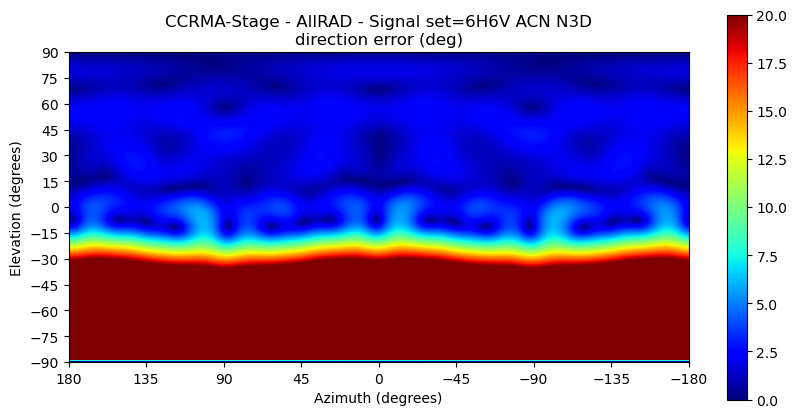

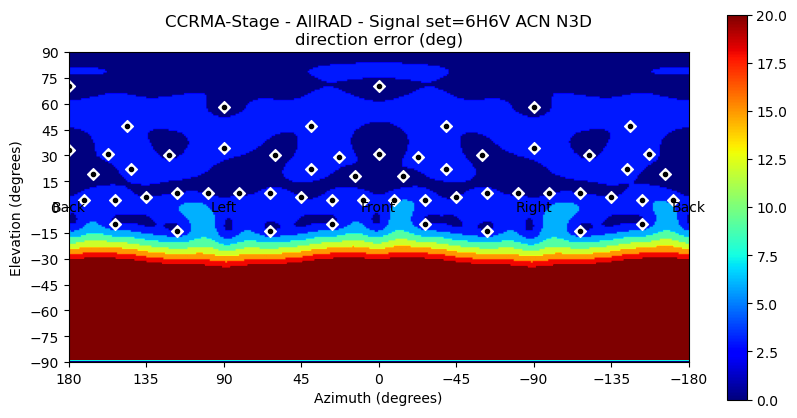

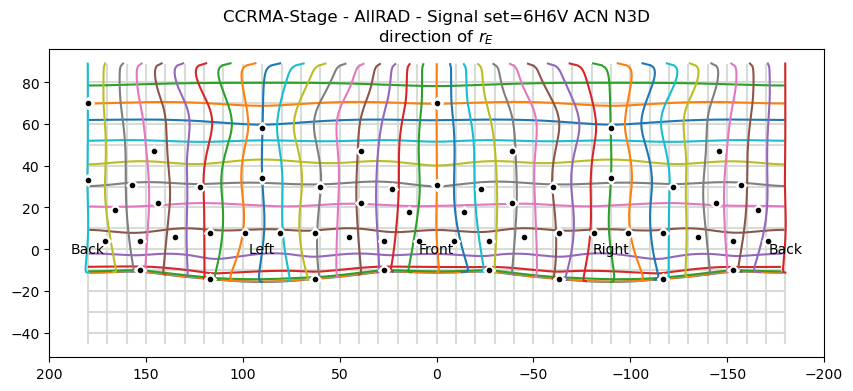

(361, 181) (361, 181) (361, 181)


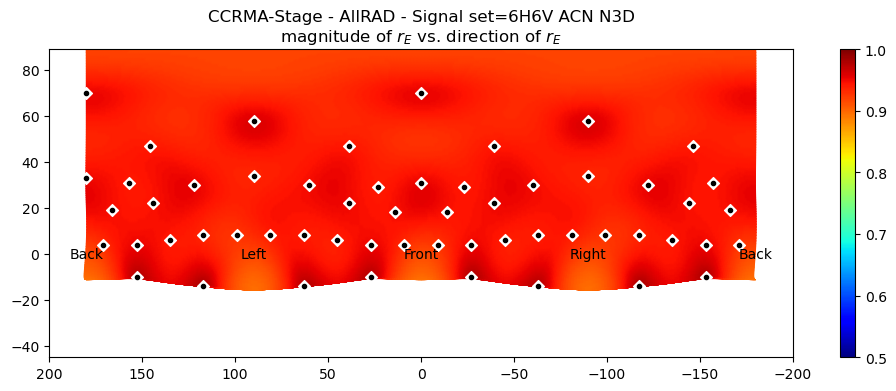

(361, 181) (361, 181) (361, 181)


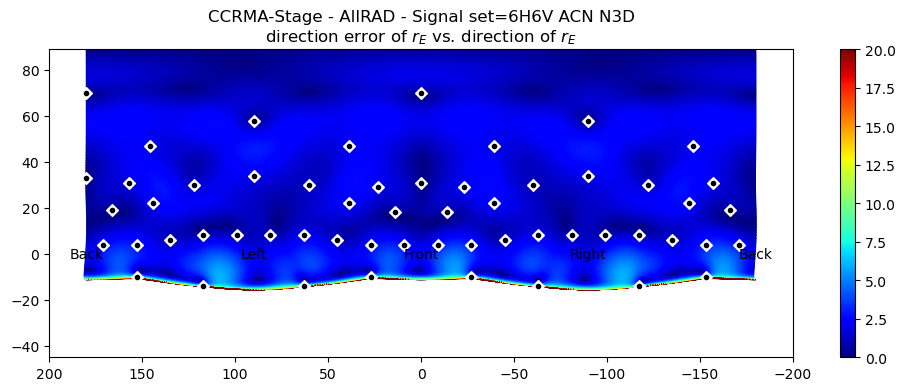

(361, 181) (361, 181) (361, 181)


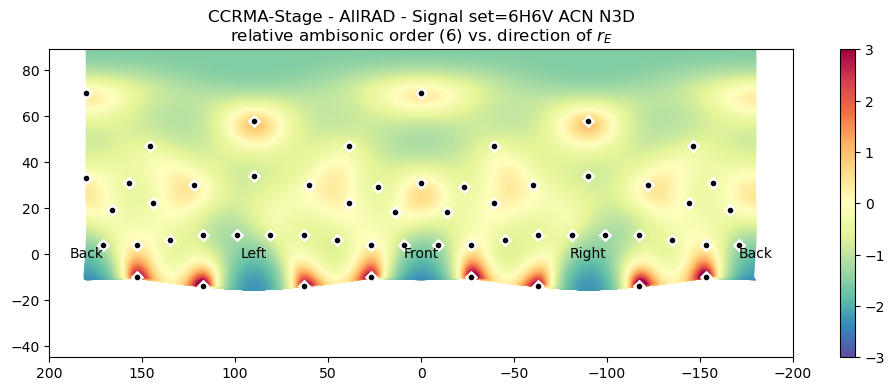

(361, 181) (361, 181) (361, 181)


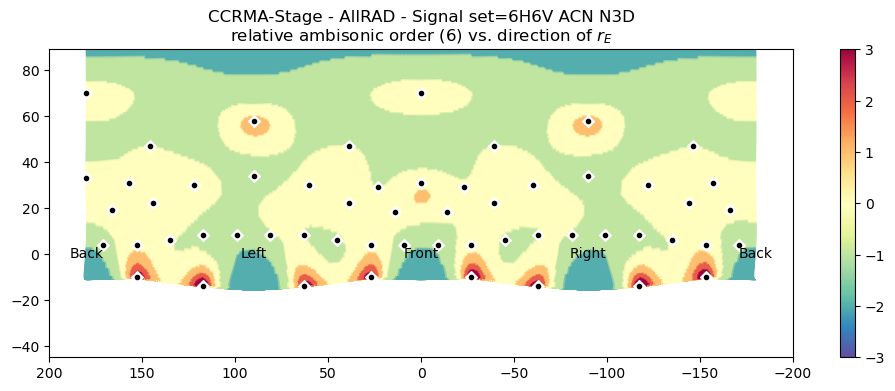

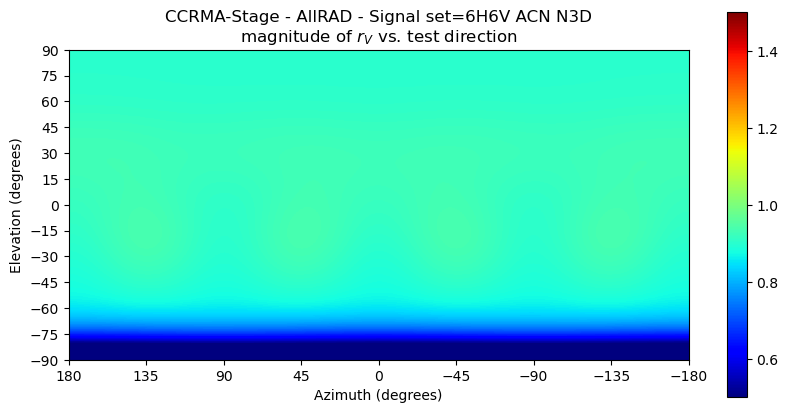

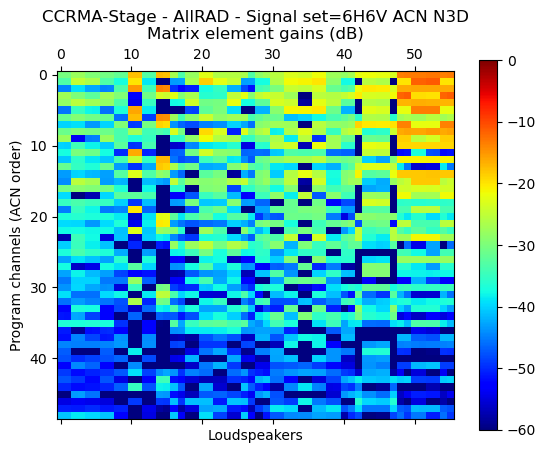



CCRMA-Stage - AllRAD - Signal set=6H6V ACN N3D
Diffuse field gain of each loudspeaker (dB)
S01:  -14.66 |=============================================
S02:  -14.69 |=============================================
S03:  -12.52 |===============================================
S04:  -12.51 |===============================================
S05:  -13.95 |==============================================
S06:  -13.96 |==============================================
S07:  -14.71 |=============================================
S08:  -14.71 |=============================================
S09:  -15.96 |============================================
S10:  -15.99 |============================================
S11:   -5.26 |======================================================
S12:   -5.27 |======================================================
S13:  -16.91 |===========================================
S14:  -16.92 |===========================================
S15:   -4.95 |===================================

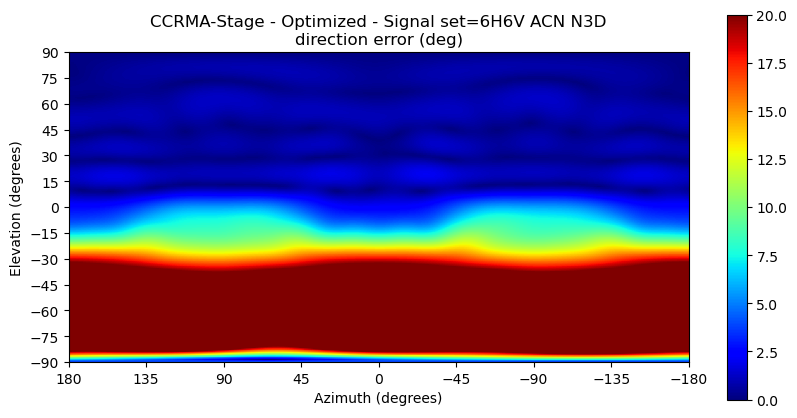

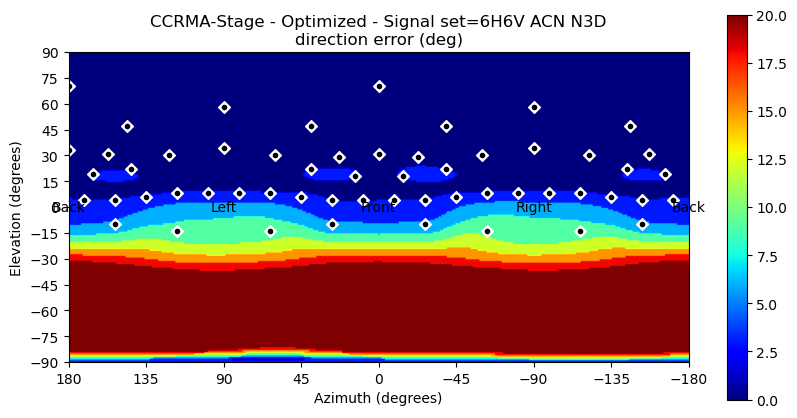

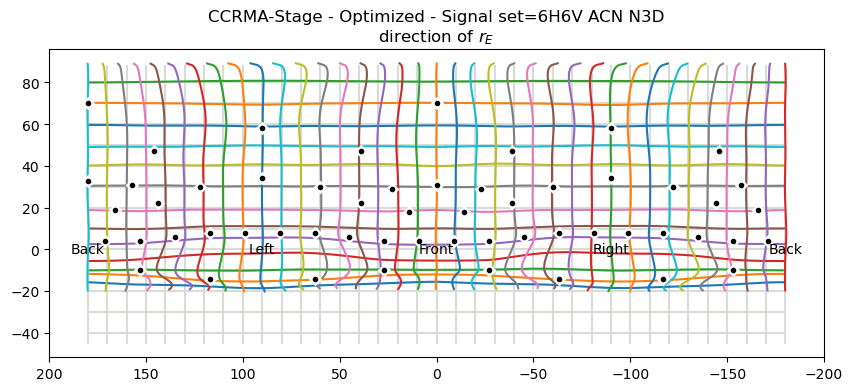

(361, 181) (361, 181) (361, 181)


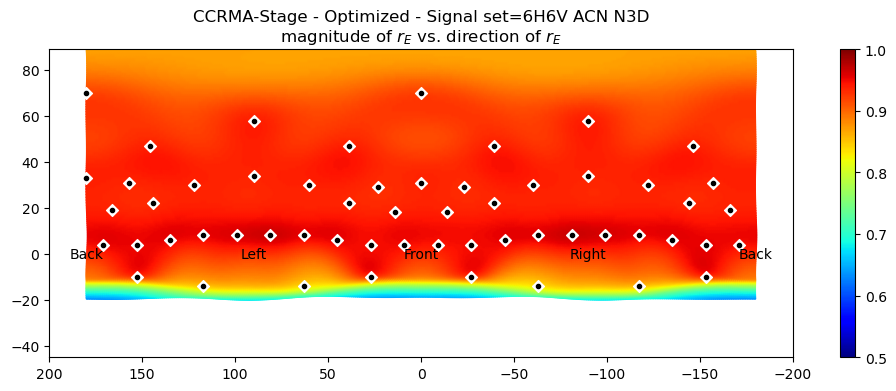

(361, 181) (361, 181) (361, 181)


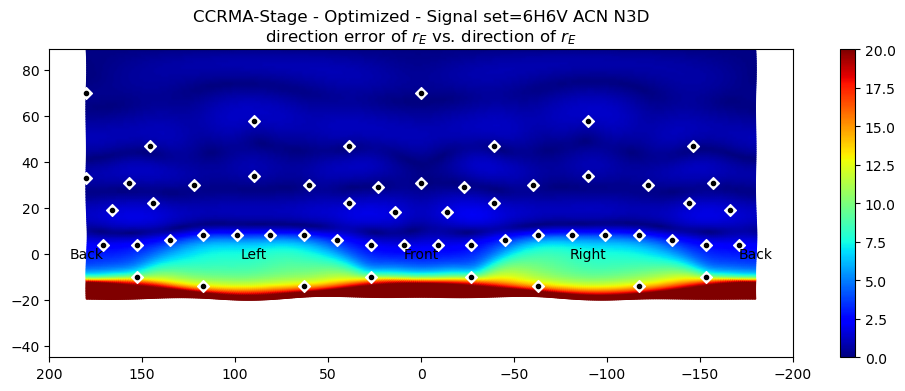

(361, 181) (361, 181) (361, 181)


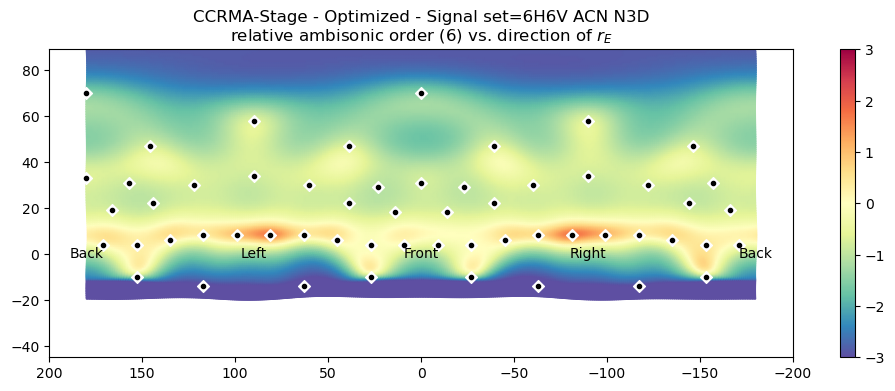

(361, 181) (361, 181) (361, 181)


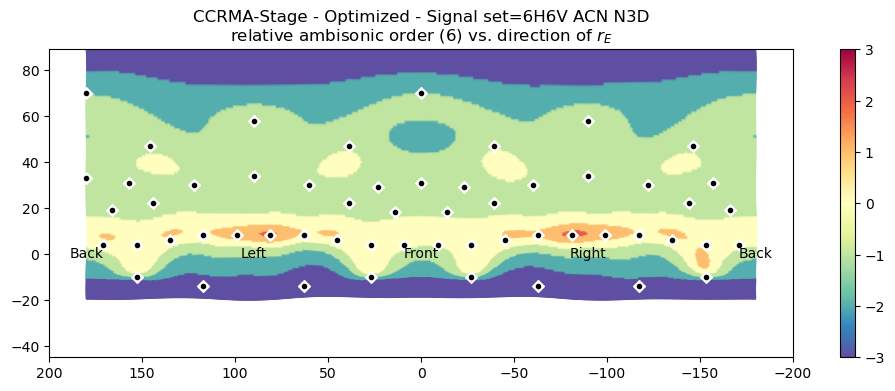

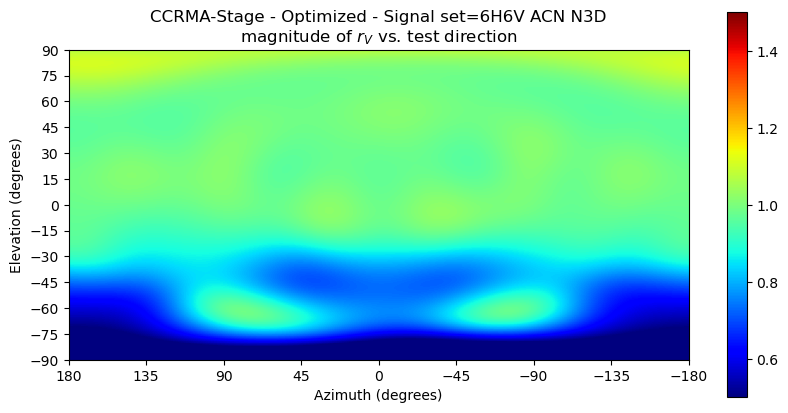

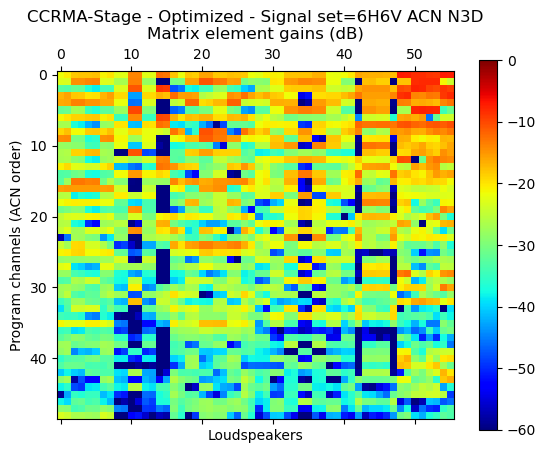

2023-04-01 11:25:23

 ambisonic_order = 6
el_lim = -30.0000 .. 60.0000
tikhonov_lambda = 0.001
sparseness_penalty = 1

Using:
 ['S01' 'S02' 'S03' 'S04' 'S05' 'S06' 'S07' 'S08' 'S09' 'S10' 'S11' 'S12'
 'S13' 'S14' 'S15' 'S16' 'D17' 'D18' 'D19' 'D20' 'D21' 'D22' 'D23' 'D24'
 'D25' 'D26' 'D27' 'D28' 'D29' 'D30' 'D31' 'D32' 'D33' 'D34' 'D35' 'D36'
 'D37' 'D38' 'D39' 'D40' 'D41' 'D42' 'D43' 'D44' 'D45' 'D46' 'D47' 'D48'
 'L01' 'L02' 'L03' 'L04' 'L05' 'L06' 'L07' 'L08']
Turned off:
 []


Diffuse field gain of each loudspeaker (dB)
S01:   -6.56 |=====================================================
S02:   -5.93 |======================================================
S03:   -5.24 |======================================================
S04:   -5.24 |======================================================
S05:   -5.41 |======================================================
S06:   -5.33 |======================================================
S07:   -6.54 |==========================================

 This problem is unconstrained.



At iterate  150    f=  4.07604D+00    |proj g|=  1.06207D+00

At iterate  200    f=  3.94714D+00    |proj g|=  2.23807D+00

At iterate  250    f=  3.87031D+00    |proj g|=  2.23852D+00

At iterate  300    f=  3.83651D+00    |proj g|=  1.07382D+00

At iterate  350    f=  3.81200D+00    |proj g|=  1.01931D+00

At iterate  400    f=  3.79134D+00    |proj g|=  9.29151D-01

At iterate  450    f=  3.78428D+00    |proj g|=  5.51269D-01

At iterate  500    f=  3.77751D+00    |proj g|=  1.09172D+00

At iterate  550    f=  3.77380D+00    |proj g|=  9.39014D-01

At iterate  600    f=  3.77112D+00    |proj g|=  8.18709D-01

At iterate  650    f=  3.76685D+00    |proj g|=  7.73842D-01

At iterate  700    f=  3.75880D+00    |proj g|=  2.29962D+00

At iterate  750    f=  3.74997D+00    |proj g|=  1.77426D+00

At iterate  800    f=  3.73639D+00    |proj g|=  1.12053D+00

At iterate  850    f=  3.72077D+00    |proj g|=  1.07737D+00

At iterate  900    f=  3.70885D+00    |proj g|=  1.36386D+00

At iter

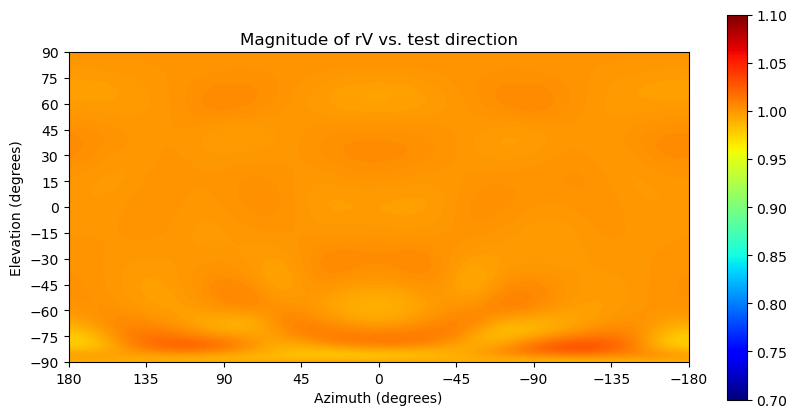

mean rV/rE direction error = 1.0705 degrees


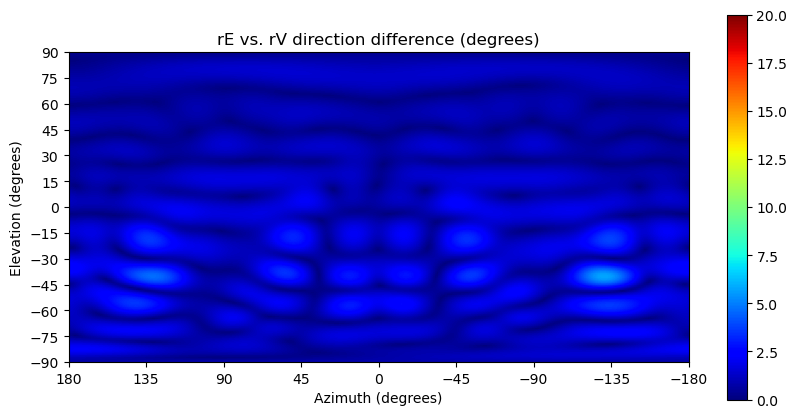

In [10]:
run_it()

In [11]:
run_it()

Done!


In [11]:
run_it()

Done!


In [12]:
run_it()

Done!


In [13]:
run_it()

Done!


In [14]:
run_it()

Done!


In [15]:
run_it()

Done!


In [16]:
run_it()

Done!


In [17]:
dsps

['CCRMA-Stage-6h6v_acn_n3d-vienna.dsp']

In [18]:
!mkdir -p win32
!mkdir -p win64
!mkdir -p macos64

for dsp in dsps:
    d = Path(dsp)
    print(dsp, d.stem)
    #os.system(f"~/bin/faust2vst-ajh {dsp}; mv {d.stem}.vst macos64")
    os.system(f"faust2faustvst {dsp}; rm -rf macos64/{d.stem}.vst && mv {d.stem}.vst macos64")
    #os.system(f"faust2w32vst {dsp}")
    #os.system(f"faust2w64vst {dsp}; mv {d.stem}.dll win64")
    #os.system(f"~/src/audio/faust-2022/faust/tools/faust2appls/faust2w64vst-dbg {d}")
    


CCRMA-Stage-6h6v_acn_n3d-vienna.dsp CCRMA-Stage-6h6v_acn_n3d-vienna


clang: error: no such file or directory: '/usr/local/src/vstsdk/public.sdk/source/vst2.x/vstplugmain.cpp'
clang: error: no such file or directory: '/usr/local/src/vstsdk/public.sdk/source/vst2.x/audioeffect.cpp'
clang: error: no such file or directory: '/usr/local/src/vstsdk/public.sdk/source/vst2.x/audioeffectx.cpp'
clang: error: the clang compiler does not support '-march=native'
mv: rename CCRMA-Stage-6h6v_acn_n3d-vienna.vst to macos64/CCRMA-Stage-6h6v_acn_n3d-vienna.vst: No such file or directory
